<a href="https://colab.research.google.com/github/andreamarin/senate-publications-analysis/blob/add%2Fnews-analysis/news_topic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!git clone https://github.com/andreamarin/senate-publications-analysis.git

Cloning into 'senate-publications-analysis'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 107 (delta 18), reused 27 (delta 7), pack-reused 45 (from 1)
Receiving objects: 100% (107/107), 1.41 MiB | 9.59 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [2]:
%cd senate-publications-analysis/nlp_classification/

/content/senate-publications-analysis/nlp_classification


In [22]:
%mkdir config

In [9]:
!pip freeze | grep pymongo

pymongo==4.3.3


In [90]:
!git pull

remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 6 (delta 4), reused 6 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 664 bytes | 221.00 KiB/s, done.
From https://github.com/andreamarin/senate-publications-analysis
   ef11240..07cbe5b  add/news-analysis -> origin/add/news-analysis
Updating ef11240..07cbe5b
Fast-forward
 nlp_classification/utils/lda_model_builder.py |  5 ++---
 nlp_classification/utils/nlp_processor.py     | 18 +++++-------------
 2 files changed, 7 insertions(+), 16 deletions(-)


In [ ]:
!git checkout add/news-analysis

Branch 'add/news-analysis' set up to track remote branch 'add/news-analysis' from 'origin'.
Switched to a new branch 'add/news-analysis'


/content/senate-publications-analysis/nlp_classification


In [ ]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 16.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2


In [ ]:
! python -m spacy download es_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 1.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
!curl ipecho.net/plain

34.171.75.81

# Imports

In [13]:
import sys
sys.path.append('/content/senate-publications-analysis/nlp_classification')

In [10]:
import os
import re
import nltk
import spacy
import importlib
import pyLDAvis.gensim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim.corpora as corpora

from functools import partial
from itertools import chain
from wordcloud import WordCloud
from operator import itemgetter
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

In [93]:
import utils.db as db
import utils.lda_model_builder as lda
import utils.nlp_processor as nlp

In [94]:
importlib.reload(lda)
importlib.reload(nlp)

<module 'utils.nlp_processor' from '/content/senate-publications-analysis/nlp_classification/utils/nlp_processor.py'>

In [23]:
conn = db.connect_mongo_db("news-data")

In [24]:
conn.list_collection_names()

['articles']

In [60]:
articles_cursor = conn.articles.find(
    projection=["newspaper", "section", "date", "text", "summary"]
  )
raw_articles_df = pd.DataFrame(articles_cursor)
raw_articles_df.head()

,_id,newspaper,section,date,summary,text
0,f5adb7c677dbd2f60d270bb33dc58fd5,Proceso,economia,2018-01-30T00:00:00,,CIUDAD DE MÉXICO (apro).- El secretario de Hac...
1,330980da03e75b9dabfb2970032a60d3,Proceso,economia,2018-01-30T00:00:00,,CIUDAD DE MÉXICO (apro).- La Comisión Federal ...
2,bc9c780c3d54918b0d52abd584424a8d,Proceso,economia,2018-01-29T00:00:00,,CIUDAD DE MÉXICO (apro).- La sexta ronda de re...
3,ebee13f285e697234ada1310f64e1933,Proceso,economia,2018-01-29T00:00:00,,CIUDAD DE MÉXICO (apro).- El final de la sexta...
4,5939aec7d17aa08449f5ff8c19a60ddf,Proceso,economia,2018-01-29T00:00:00,,CIUDAD DE MÉXICO (apro).- La Comisión Federal ...


In [64]:
raw_articles_df["summary"] = raw_articles_df.summary.apply(str.strip)

In [65]:
raw_articles_df["summary_word_length"] = raw_articles_df.summary.apply(
    lambda s: len(s.split())
)

In [83]:
# 245 192
# 481 398
empty_summary = raw_articles_df.summary_word_length <= 20
sum(empty_summary)

342383

In [84]:
round((sum(empty_summary)/raw_articles_df.shape[0])*100, 2)

71.12

array([[<Axes: title={'center': 'summary_word_length'}>]], dtype=object)

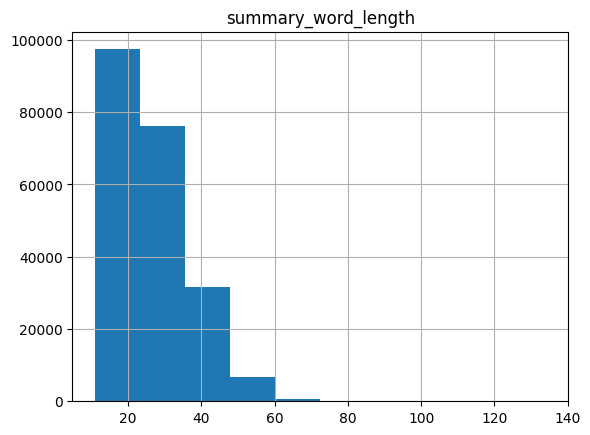

In [86]:
raw_articles_df.loc[raw_articles_df.summary_word_length > 10].hist(column="summary_word_length")

In [70]:
raw_articles_df.loc[raw_articles_df.summary_word_length > 0].summary_word_length.min()

1

In [95]:
short_summaries = raw_articles_df.loc[
    (raw_articles_df.summary_word_length > 0)
    & (raw_articles_df.summary_word_length <= 10)
].sort_values(by="summary_word_length", ascending=False)

for summary in short_summaries.summary.iloc[:20]:
  print(summary)
  print("----"*10)

Fallece un paciente en SLP; 67 contagiados en 20 estados
----------------------------------------
Lozoya: si caigo, caen todos // Pandilleros tras un amparo
----------------------------------------
La ensayista lo considera un <q>gran autor y eficaz activista</q>
----------------------------------------
Ganaderos callados pero alucinados // Las mafias y sus cómplices
----------------------------------------
No se abandonará  a los trabajadores atrapados, afirma Laura Velázquez
----------------------------------------
Para entonces deberán estar concluidos los ceses de plazas duplicadas
----------------------------------------
La <q>mafia del poder</q> del rock y sus festivales desgastantes
----------------------------------------
La ministra de Seguridad acusa a los convocantes de <q>extorsión</q>
----------------------------------------
El sistema de listas acentuaría la sub  y sobrerrepresentación, aseguran
----------------------------------------
<q>Nada cambia; el caso está cerrado

# Text pre-processing

In [96]:
def remove_tags(text: str) -> str:
  return re.sub(r"<\/?.*?>", "", text)

In [97]:
remove_tags("<q>Que la gente lleve la fiesta en paz</q>, pide Abella")

'Que la gente lleve la fiesta en paz, pide Abella'